In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics

In [2]:
model_name = 'dagmm'

In [ ]:
data = pd.read_csv('data/new_data.csv')
data.tail()

In [4]:
train_result = pd.read_csv('result/{}/train_result.csv'.format(model_name))
train_result['data'] = 'trn'

val_result = pd.read_csv('result/{}/valid_result.csv'.format(model_name))
val_result['data'] = 'val'

test_result = pd.read_csv('result/{}/test_result.csv'.format(model_name))
test_result['data'] = 'tst'

In [6]:
result = pd.concat([train_result, val_result, test_result])
result = result.sort_values(by=['date'], axis=0)
result = result.reset_index(drop=True)

result['actual'] = list(data['y0'].iloc[list(result['date'])])
result['p_idx'] = list(data['p_idx'].iloc[list(result['date'])])

result['date'] = result['date'] + 1

In [7]:
result.to_csv('./result/{}/total_result.csv'.format(model_name), index=False)

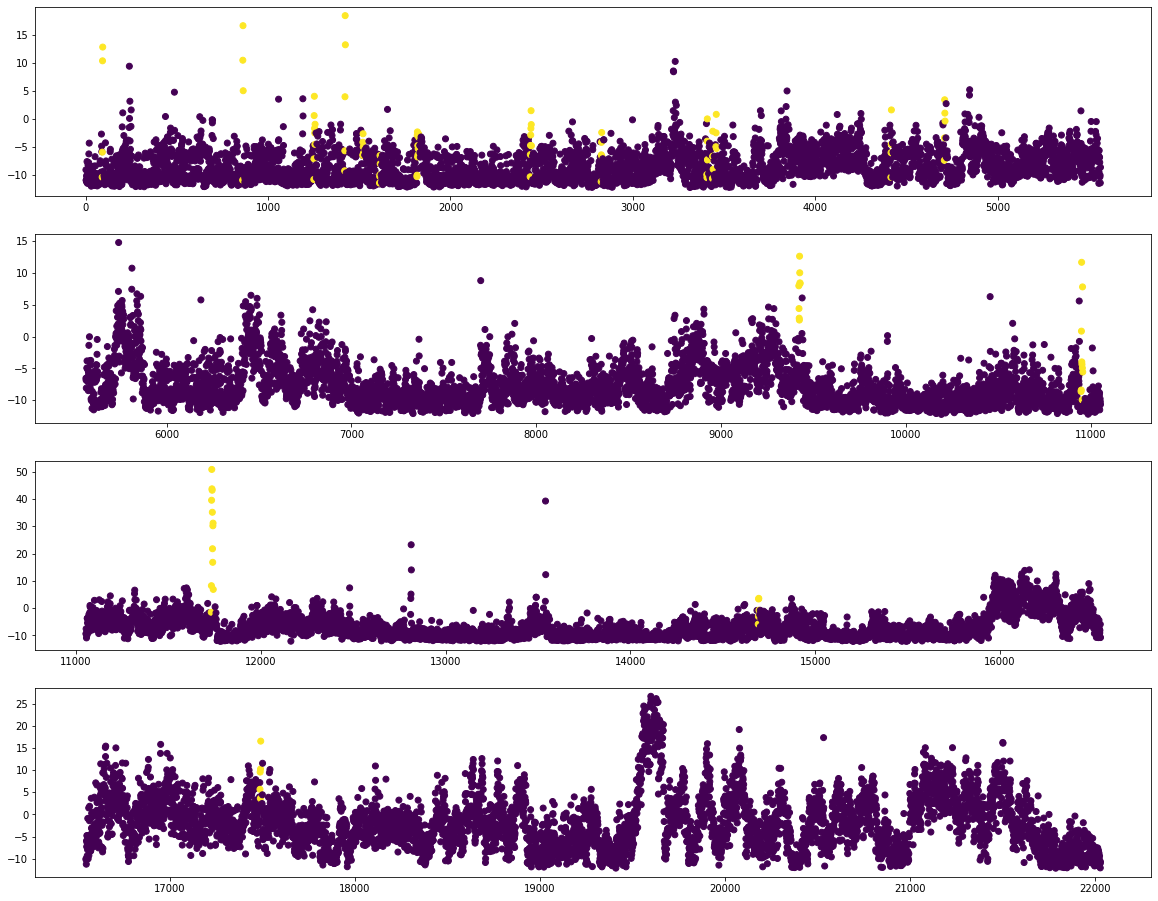

In [8]:
l = result.shape[0]
chunk = l // 4

fig, axs = plt.subplots(4, figsize=(20, 16))
for i in range(4):
    x = list(result['date'])[i * chunk: (i + 1) * chunk]
    y = list(result['actual'])[i * chunk: (i + 1) * chunk]
    score = list(result['anomaly_score'])[i * chunk: (i + 1) * chunk]
    
    axs[i].scatter(x, score, c=y)

plt.savefig('./result/{}/score_plot.jpg'.format(model_name))

In [9]:
y_true = list(result['actual'][result['data'] == 'tst'])
y_pred = list(result['anomaly_score'][result['data'] == 'tst'])

In [10]:
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred, pos_label=1)
auroc = metrics.auc(fpr, tpr)

In [11]:
auprc = metrics.average_precision_score(y_true, y_pred, pos_label=1)

In [12]:
# threshold 탐색
# score의 min ~ max 범위를 num_step개로 균등 분할한 threshold에 대하여 best threshold 탐색 
def search_best_threshold(score, y_true, num_step):
    best_f1 = 0
    best_threshold = None
    for threshold in np.linspace(min(score), max(score), num_step):
        y_pred = threshold < score

        f1 = metrics.f1_score(y_true, y_pred, pos_label=1)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    return best_f1, best_threshold

In [13]:
best_f1, best_threshold = search_best_threshold(y_pred, y_true, num_step=10000)

In [14]:
print(model_name, ': AUROC =', round(auroc, 4), '| AUPRC =', round(auprc, 4),\
      '| BestF1 =', round(best_f1, 4), 'with threshold =', round(best_threshold, 4))

dagmm : AUROC = 0.6945 | AUPRC = 0.1635 | BestF1 = 0.2059 with threshold = 9.5565
